In [119]:
# sample.py
import ctypes
import os
import threading
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import math
import concurrent.futures
import glob
import json
import scipy as sp
import scipy.special
from matplotlib.ticker import FormatStrFormatter

# Running model as a subprocess

In [2]:
# Try to locate the .so file in the same directory as this file
#_file = 'libeemodel.dylib'
_file = '/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug/libeemodel.dylib'

_path = os.path.join(*(os.path.split(_file)[:-1] + (_file,)))
_mod = ctypes.cdll.LoadLibrary(_path)

In [3]:
#check that library is loaded
print(_mod)

<CDLL '/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug/libeemodel.dylib', handle 107f337d0 at 0x104bec080>


In [4]:
# parameters for the model
args = [b'0', b'NEW', b'/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Source/Examples/EEModel/eemodel.model']
args_C = (ctypes.c_char_p * len(args))()
args_C[:] = args
#alternative for setting args_C (not tested)
#args_C = (ctypes.c_char_p * len(args))(*args)
#and could use create_string_buffer("string") to create array of strings

In [5]:
#ctypes definitions of functions that could be called
_mod.init_model.restype = ctypes.c_void_p
_mod.init_model.argtypes = [ctypes.c_int , ctypes.POINTER(ctypes.c_char_p)]
_mod.run_model.restype = ctypes.c_int
_mod.run_model.argtypes = [ctypes.c_void_p]
_mod.C_API_run_model_steps.restype = ctypes.c_int
_mod.C_API_run_model_steps.argtypes = [ctypes.c_void_p, ctypes.c_int]

class HUIBL(ctypes.Structure):
    _fields_ = []
    
_mod.C_API_estimate_profit.restype = ctypes.c_double
_mod.C_API_estimate_profit.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]
_mod.C_API_estimate_irr.restype = ctypes.c_double
_mod.C_API_estimate_irr.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]
_mod.C_API_estimate_demand_sei_params.restype = ctypes.c_double
_mod.C_API_estimate_demand_sei_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int, \
                                       ctypes.c_double, ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
_mod.C_API_estimate_demand_w_params.restype = ctypes.c_double
_mod.C_API_estimate_demand_w_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_double]
_mod.C_API_estimate_irr_params.restype = ctypes.c_double
_mod.C_API_estimate_irr_params.argtypes = [ctypes.POINTER(HUIBL), ctypes.c_int , ctypes.c_double]


In [6]:
#initializing model and getting ui pointer from initialization
huibl_void = _mod.init_model(len(args_C), args_C)

In [7]:
#check that it is inilialized
print(huibl_void)

4302062016


In [8]:
#get pointer to handle of UIBL type
huibl = ctypes.cast(huibl_void, ctypes.POINTER(HUIBL))

In [ ]:
#wrapper function to run model to be used in concurrent, runs for all predetermined steps
def run_model(huibl_void):
    _mod.run_model(huibl_void)

In [ ]:
#wrapper function to run model for fixed number of steps to be used for testing
def run_model_step(huibl_void):
    _mod.C_API_run_model_steps(huibl_void, 1)

In [ ]:
#estimate profit from price
def estimate_profit(huibl, p):
    return _mod.C_API_estimate_profit(huibl, 0, p)

In [ ]:
#estimate irr from price
def estimate_irr(huibl, p):
    return _mod.C_API_estimate_irr(huibl, 0, p)

In [9]:
#estimate irr for given efficiency, other parameters are default
def estimate_irr(huibl, eff):
    return _mod.C_API_estimate_irr_params(huibl, 0, eff)

In [ ]:
#estimate demand for irr
def estimate_demand(huibl, irr):
    return _mod.C_API_estimate_demand_w_params(huibl, irr)

In [ ]:
#parameters for demand estimation, synchronized with sei.json
scale_factor = 4.75
theta = np.array([-0.005, 1.25, 0.005, -0.5, -0.005]) * scale_factor

In [ ]:
#create vector for ctypes to pass it to C_API
theta_C = (ctypes.c_double * len(theta))()
theta_C[:] = theta

In [ ]:
#estimate demand for price and set demand function form
def estimate_demand(huibl, p):
    return _mod.C_API_estimate_demand_sei_params(huibl, 0, p, len(theta_C), theta_C)

In [ ]:
#estimate demand given price and use internal parameters
def estimate_demand(huibl, p):
    return _mod.C_API_estimate_demand(huibl, 0, p)

In [ ]:
#run model for 1 step at a time
run_model_step(huibl_void)

# Code snippets, not in use now but might decide to use

In [ ]:
#running model after it is initialized
res2 = _mod.run_model(huibl_void)

#test run model to check that could get parameters through
res = _mod.run_model_test( len(args_C_), args_C_)

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(run_model, huibl_void)
#alternative that does not work is with threads
#t1 = threading.Thread(target=_mod.run_model, args = [res])
#t1.start()    
#t1.join()

In [ ]:
#it is code to check that could do concurrent execution
#curent implementation does not use it, because it runs without any concurrency 
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(run_model_step, huibl_void)

# Visuals for simulation results, initial parameters sensitivity

## Graph for expected time before next maintenance. NOT UPDATED

In [ ]:
lambda_ = 2500
alpha = 100
y = np.zeros(100)
x = np.zeros(100)
i = 0


for step in np.linspace(0.01, 25, num=100):
    x[i] = step
#    y[i] = lambda_ * math.pow((1 - x[i]), -(1/alpha)) - 1
    #cdf
    y[i] = 1 - math.pow(1 + x[i]/lambda_, - alpha)
    i = i + 1
#draw graph
plt.plot(x, y)

## Estimate scale factor. Given generic demand function, estimate scaling factor to bring demand estimation into [0,1] range approximately.

In [ ]:
theta = np.array([-0.005, 1.25, 0.005, -0.5, -0.005])

#assume equal reputation, equal high irr as priors 
irr_i = 0.1
rep = 1
rep_i = 1
irr = irr_i
X = np.array([1, irr, rep, irr_i, rep_i])


#split market equally given number of agents
N = 3

sum = np.dot(X, theta)
print(sum)

scale_factor = 1/sum/N
print (scale_factor)

theta = theta * scale_factor

## Draw demand share for the range of irrs. Uses theta from the above estimation, so it needs to be run before to get accurate estimation. 

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 0.4, num=100):
    x[i] = step
    X[1] = x[i]
    y[i] = np.dot(X, theta)
    i = i + 1
#draw graph
plt.plot(x, y)

## Draw irr for the range of efficiencies. Just to see how it reacts.

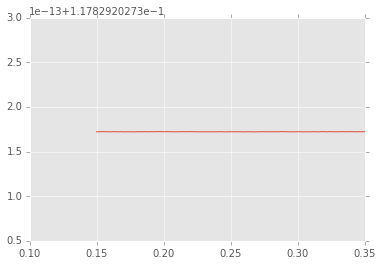

In [11]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.15, 0.35, num=100):
    x[i] = step
    y[i] = estimate_irr(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Draw demand share as a function of reasonable price range. Python estimation for the demand part and irr rom the simulation.

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    X[1] = estimate_irr(huibl, x[i])
    y[i] = np.dot(X, theta)
    i = i + 1
#draw graph
plt.plot(x, y)

# Graph for expected profit given price

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 10.0, num=100):
    x[i] = step
    y[i] = estimate_profit(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)


# Graph for expected irr given price

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    y[i] = estimate_irr(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)


# Graph for expected demand given price. C++ code for demand estimation all the way through. 

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(2, 10.0, num=100):
    x[i] = step
    y[i] = estimate_demand(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Graph for realized demand given irr, C++ code. To run need for Python to have correct estimate_demand version for irr estimation. Check what definition was runs from the definition section above.

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
for step in np.linspace(0.01, 0.99, num=100):
    x[i] = step
    y[i] = estimate_demand(huibl, x[i])
    i = i + 1
#draw graph
plt.plot(x, y)

## Inverse-Gamma

In [ ]:
y = np.zeros(100)
x = np.zeros(100)
i = 0
beta = 1
alpha = 3
for step in np.linspace(0.01, 10.0, num=100):
    x[i] = step
    y[i] = math.pow(beta, alpha) * math.pow(x[i], -alpha-1)*math.exp(-beta/x[i])/sp.special.gamma(alpha)
    i = i + 1
#draw graph
plt.plot(x, y)

## H decision parameters, sensitivity of a threshold to income level

In [ ]:
#parameters
THETA_params = [1, 3, 0.02]
THETA_decision = [0, 0]
THETA_decision[0] = 1/THETA_params[1] * math.pow((1 + THETA_params[0]/THETA_params[1] * 50000 / 1000),-1/(THETA_params[0] + 1))
print(THETA_decision[0])
THETA_decision[1] = THETA_params[2]

In [ ]:
#threshold
y = np.zeros(100)
x = np.zeros(100)
i = 0
a = 0.5
for step in np.linspace(30000, 100000, num=100):
    x[i] = step
    y[i] = 1/THETA_params[1] * math.pow((1 + THETA_params[0]/THETA_params[1] * x[i] / 1000),-1/(THETA_params[0] + 1))
    i = i + 1
#draw graph
plt.plot(x, y)

In [ ]:
#probability
y = np.zeros(100)
x = np.zeros(100)
i = 0
a = 0.5
for step in np.linspace(0.01, 0.1, num=100):
    x[i] = step
    y[i] = (1/(1+math.exp(-((x[i] + 0.15)*a - THETA_decision[0])/THETA_decision[1])))
    i = i + 1
#draw graph
plt.plot(x, y)

# Model for the market

In [ ]:
#assume that California is half of the market 
#And SolarCity is half of the regional market 
#cost per watt marketing is 0.48
#total amount installed

In [ ]:
marketing_costs = 227*1000*0.48*1000
marketing_costs

In [ ]:
#wage for calculations
w = 20

In [ ]:
marketing_hours = marketing_costs/w
marketing_hours

In [ ]:
#get number of people, assume 1 person works 2400 per year. it checks that size of marketing department is reasonable
marketing_hours/2400

In [ ]:
#total number of installations
#divide total installed amount in MWatts by an average size of installation 
227*1000/6.7

In [ ]:
#Model for california
#number of installations
N_installations_ca = 30000

In [ ]:
#GA costs from SolarCity financial report
g_a_costs = 86097000
g_a_hours = g_a_costs/w
g_a_hours

In [ ]:
#solar panel output
STC_panel = 0.26
system_size = 6
N_panels = system_size/STC_panel
N_panels

In [ ]:
#additional costs
#they state installation costs being $2 and substract production costs of 0.5 per watt
labor_hours = system_size * 1000 * (2 - 0.5)/w
#total labor hours in my model need to sum up to the estimate of labor hours for solarcity
labor_hours

In [ ]:
#Assume for california yearly market size as 30000 (very optimistic) 
#scale fixed costs accordingly - basically Solarcity is US - which is 50/50 California 
#and the rest and 50 percent of the market 
#they have roughly 30000 installations for US
#15000 - assume in CA and adjust for the market size - total will be 30000 - rought estimate
#Sep 14 2016 - adjusted to be 50000 - slightly higher and share of solar city is assumed to be lower

In [ ]:
# DO NOT REMEMBER, LOOK UP
1559*1000/1000000*0.25

In [22]:
#already installed 149,141 CA resudential https://www.californiasolarstatistics.ca.gov/reports/agency_detail/
#total number of households - http://www.infoplease.com/us/census/data/california/housing.html
#1 unit detached 6,883,493

149141/6883493


0.021666470787433067

# Graphs for simulation results

## Read data.

In [ ]:
#read last simulation result
file = max(glob.iglob('../../ABMIRISLab/Saves/EEModel/*.csv'), key=os.path.getmtime)
print(file)

In [ ]:
#names of columns in a file
names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
for i in range(3):
    names.append('sei_' + str(i))

In [ ]:
df = pd.read_csv(file, names=names, low_memory=False)

In [ ]:
df.head()

## Plot number of installation versus price

In [ ]:
#plot number of installation versus price
l1, l2 = plt.plot(df.index.values, df['N_installed'], '--go', df.index.values, df['sei_0'], '.')
plt.legend( (l1, l2), ('Number installations', 'P_av'), loc='upper right', shadow=True)
plt.xlabel('time')
plt.ylabel('simulation results')
plt.title('Different simulation parameters')
plt.show()

## Read results of multiple simulations.

In [125]:
#names of columns in a file
names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
for i in range(3):
    names.append('sei_' + str(i))


#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('../../ABMIRISLab/Saves/EEModel/*.csv')
files = glob.glob('/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Saves/EEModel/*[_w].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top 4 files 
for file in files[4:8]:
    df_ = pd.read_csv(file, names=names, low_memory=False)
    dfs_.append(df_)

#create df from them    
df_concat = pd.concat(dfs_)
df = df_concat.groupby(level=0).mean()
df_std = df_concat.groupby(level=0).std()

#alternative way to calculate means
by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_means.head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_0,sei_1,sei_2
0,27.75,27.75,3.597317,3.780130,0.179222,0.160268,0.169890
1,25.50,53.25,3.827048,3.893740,0.184745,0.162641,0.195375
2,23.75,77.00,3.802782,3.861627,0.173961,0.170977,0.194952
3,19.75,96.75,3.754537,3.816978,0.189286,0.180560,0.217889
4,19.50,116.25,3.720328,3.850557,0.210649,0.195678,0.204552


In [126]:
#names of columns in a file
names = ['Income', 'ElectricityBill', 'House_size', 'bInstalled']


#read few files
#save into database
dfs_hos_ = []
#read last simulation result
files = glob.glob('../../ABMIRISLab/Saves/EEModel/*.csv')
files = glob.glob('/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Saves/EEModel/*[_hos].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top 4 files 
for file in files[4:8]:
    df_ = pd.read_csv(file, names=names, low_memory=False)
    dfs_hos_.append(df_.reset_index(drop=True))

#create df from them    
df_hos_concat = pd.concat(dfs_hos_, axis=0, ignore_index=True)

df_hos_concat.describe()

,Income,ElectricityBill,House_size,bInstalled
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,129549.979152,158.962051,2690.244175,0.474750
std,125442.640503,103.949252,1548.148773,0.499424
min,83.699800,0.268152,110.363000,0.000000
25%,57810.975000,89.419575,1659.355000,0.000000
50%,95078.700000,139.542500,2371.640000,0.000000
75%,153117.000000,215.028500,3355.317500,1.000000
max,1425550.000000,1003.490000,17558.900000,1.000000


In [127]:
bins_income = [0, 2499, 4999, 7499, 9999, \
    14999, 19999, 24999, 29999, 34999, 39999, \
    44999, 49999, 54999, 59999, 64999, \
        69999, 74999, 79999, 84999, 89999, \
        94999, 99999, 119999, np.inf]

df_hos_concat['Income_C'] = pd.cut(df_hos_concat['Income'], \
                                   bins = bins_income, labels = False, retbins=True)[0]


y_1 = df_hos_concat.groupby('Income_C')['bInstalled'].mean()
y_1_std = df_hos_concat.groupby('Income_C')['bInstalled'].std()


In [128]:
bins_elect = np.array([17.0, 6276.875, 12536.75, 18796.625, 25056.5, 31316.375, \
          37576.25, 43836.125, 50096.0, 56355.875, 62615.75, 68875.625, "Infinity"], dtype = np.float32)

bins_elect = bins_elect*0.15/365.25*30

df_hos_concat['ElectricityBill_C'] = pd.cut(df_hos_concat['ElectricityBill'], \
                                   bins = bins_elect, labels = False, retbins=True)[0]
y_2 = df_hos_concat.groupby('ElectricityBill_C')['bInstalled'].mean()
y_2_std = df_hos_concat.groupby('ElectricityBill_C')['bInstalled'].std()

for i in range(len(bins)):
    if not (i in y_2.index.values):
        y_2.loc[i] = 0.0
        
y_2 = y_2.sort_index()

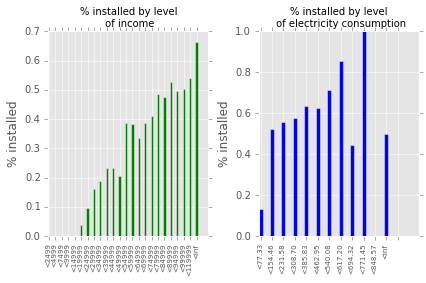

In [129]:
N = 24
ind_1 = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(bottom=0.25)

plt1 = axes[0].bar(ind_1, y_1, width, color='g')#, yerr=y_std)

axes[0].set_ylabel('% installed')
axes[0].set_title('% installed by level \n of income', fontsize=10)
axes[0].set_xticks(ind + width/2)
axes[0].set_xticklabels(tuple(["{}{}".format(a_, b_) for a_, b_ in zip(['<'] * N, bins_income[1:])]), rotation=90, fontsize=7)


ind_2 = np.arange(13)
axes[1].bar(ind_2, y_2, width, color='b')
axes[1].set_xticklabels(tuple(["{}{:.2f}".format(a_, b_) for a_, b_ in zip(['<'] * N, bins_elect[1:])]), rotation=90, fontsize=7)
axes[1].set_ylabel('% installed')
axes[1].set_title('% installed by level \n of electricity consumption', fontsize=10)
axes[1].set_xticks(ind_2 + width/2)
#axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.tight_layout()

plt.savefig('Simulation_results3.png', dpi=300)
plt.show()

## How to draw graphs below
[1](http://matplotlib.org/1.4.1/examples/ticks_and_spines/spines_demo_bounds.html)
[2](http://matplotlib.org/1.4.1/examples/pylab_examples/multiple_yaxis_with_spines.html)
[3](http://matplotlib.org/api/markers_api.html#module-matplotlib.markers)
[4](http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.plot)

/Users/wilfeli/anaconda/envs/aimacro/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


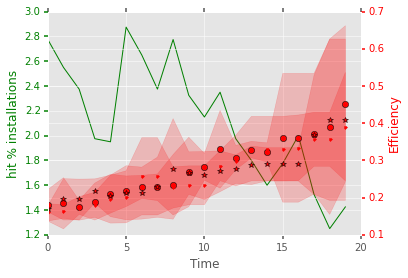

In [130]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.85)

par1 = host.twinx()


p1, = host.plot(df.index.values, df['N_installed']/1000*100, "g-", label="% installations")
p2, = par1.plot(df.index.values, df['sei_0'], "ro", label="Efficiency")
par1.plot(df.index.values, df['sei_1'], "r.")
par1.plot(df.index.values, df['sei_2'], "r*")

par1.fill_between(df.index.values, 
                  df['sei_0']-2*df_std['sei_0'], 
                  df['sei_0']+2*df_std['sei_0'], 
                  color='r', 
                  alpha=0.2)

par1.fill_between(df.index.values, 
                  df['sei_1']-2*df_std['sei_1'], 
                  df['sei_1']+2*df_std['sei_1'], 
                  color='r', 
                  alpha=0.2)

par1.fill_between(df.index.values, 
                  df['sei_2']-2*df_std['sei_2'], 
                  df['sei_2']+2*df_std['sei_2'], 
                  color='r', 
                  alpha=0.2)


host.set_xlabel("Time")
host.set_ylabel("hit % installations")
par1.set_ylabel("Efficiency")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

#host.legend(lines, [l.get_label() for l in lines])
plt.savefig('Simulation_results1.png', dpi=300)
plt.show()



/Users/wilfeli/anaconda/envs/aimacro/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


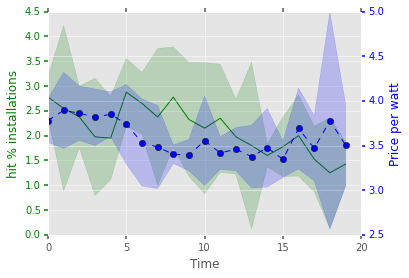

In [131]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.85)

par1 = host.twinx()


p1, = host.plot(df.index.values, df['N_installed']/1000*100, "g-", label="% installations")
p2, = par1.plot(df.index.values, df['P_av'], "--bo", label="Price")

#add +- 2 std
host.fill_between(df.index.values, 
                  df['N_installed']/1000*100-2*df_std['N_installed']/1000*100, 
                  df['N_installed']/1000*100+2*df_std['N_installed']/1000*100, 
                  color='g', 
                  alpha=0.2)

par1.fill_between(df.index.values, 
                 df['P_av']-2*df_std['P_av'],
                 df['P_av']+2*df_std['P_av'],
                  color='b', 
                  alpha=0.2)

host.set_xlabel("Time")
host.set_ylabel("hit % installations")
par1.set_ylabel("Price per watt")


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

#host.legend(lines, [l.get_label() for l in lines])
plt.savefig('Simulation_results2.png', dpi=300)
plt.show()

## Number of installations per income level

# Run number of simulations with different seeds

In [23]:
#change back to starting directory so that all relative code works

In [24]:
%cd /Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model

/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model


In [97]:
#read setup file and change seed
file = '../../ABMIRISLab/Source/Examples/EEModel/w.json'
file = '/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Source/Examples/EEModel/w.json'

mode="NEW"
model_file="/Users/wilfeli/Dropbox/ABM/SolarPanels/ABMIRISLab/Source/Examples/EEModel/eemodel.model"
    
with open(file) as infile:
    w_setup = json.load(infile)
    
for seed in (2016, 2015, 2014, 2012):
    w_setup['SEED'] = seed
    with open(file, 'w') as outfile:
        json.dump(w_setup, outfile)
        
    #run simulation 
    %cd /Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
    !./SolarEE $mode $model_file
    %cd /Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model

/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Fri 2016-09-16 09:11:49  INFO: started running
time: Fri 2016-09-16 09:11:52  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Fri 2016-09-16 09:12:00  INFO: started running
time: Fri 2016-09-16 09:12:02  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Fri 2016-09-16 09:12:09  INFO: started running
time: Fri 2016-09-16 09:12:12  INFO: stopped running
/Users/wilfeli/Dropbox/ABM/SolarPanels/solar-model/Model
/Users/wilfeli/Library/Developer/Xcode/DerivedData/ABMSolar-gkzppcalpbhpwocspomkmqhbbhyr/Build/Products/Debug
time: Fri 2016-09-16 09:12:20  INFO: started running
time: Fri 2016-09-

In [ ]:
%lsmagic